# Explorative Analysis of EMP soil data

## 1. Data & library import

In [1]:
import numpy as np
import scipy
import csv 
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import TruncatedSVD
warnings.filterwarnings("ignore")

import numpy as np
from sklearn.decomposition import PCA

In [2]:
from biom import example_table

High level Exploration: matrix information for the 2k subset

In [3]:
from biom import load_table
table = load_table('../data/emp_deblur_100bp.subset_2k.biom')

## 2. Data Statistics

In [4]:
print("Shape of table:",table.shape)
print("First 10 sample IDs", table.ids()[:10])

print("Non zero values",table.nnz)
print("Density of table",table.get_table_density())

Shape of table: (329819, 1856)
First 10 sample IDs ['1734.BD.NBS1055' '1001.SKD6' '662.M22' '804.H02.072605.R0715'
 '1035.UQ888' '1774.7.Oral.Puer' '804.3873.1233B'
 '722.CL3.1.s.1.1.sequence' '1197.SE.20101008.GY.LBNL11.BC.186'
 '804.LS11.72a']
Non zero values 1905308
Density of table 0.0031125156838897323


## 3. Check Meta-data

In [5]:

table.metadata(axis = 'sample')
table.metadata(axis = 'observation')

(defaultdict(<function biom.table.Table._cast_metadata.<locals>.cast_metadata.<locals>.<lambda>>,
             {'taxonomy': ['k__Bacteria',
               'p__Bacteroidetes',
               'c__Bacteroidia',
               'o__Bacteroidales',
               'f__Prevotellaceae',
               'g__Prevotella',
               's__melaninogenica']}),
 defaultdict(<function biom.table.Table._cast_metadata.<locals>.cast_metadata.<locals>.<lambda>>,
             {'taxonomy': ['k__Bacteria',
               'p__Acidobacteria',
               'c__Acidobacteria-6',
               'o__iii1-15',
               'f__mb2424',
               'g__',
               's__']}),
 defaultdict(<function biom.table.Table._cast_metadata.<locals>.cast_metadata.<locals>.<lambda>>,
             {'taxonomy': ['k__Bacteria', 'p__Bacteroidetes']}),
 defaultdict(<function biom.table.Table._cast_metadata.<locals>.cast_metadata.<locals>.<lambda>>,
             {'taxonomy': ['k__Bacteria',
               'p__Bacteroidete

## 4. Load mapping files and extract sample IDs for soils

In [6]:
# loading map file for 2k subset

df = pd.read_csv('../data/emp_qiime_mapping_subset_2k.tsv', sep='\t')
df_soil = df.loc[df['env_material'].isin(['soil'])]
print("Filtered # soil samples based on ENV_material ontology : ",len(df_soil))



Filtered # soil samples based on ENV_material ontology :  117


In [7]:

ids_soil = df_soil['#SampleID'].tolist()


ids_soil_in_table = set(ids_soil) & (set(table.ids()))
table_soil = table.filter(ids_soil_in_table, axis = 'sample')

# Convert table into relative abundances, normalized within each sample (sum up to 1 column-wise)
normed_soil = table_soil.norm(axis='sample', inplace=False)

## 5. Analysis for soil OTU table

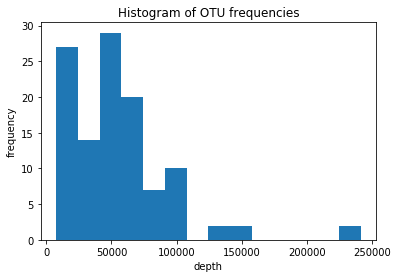

In [8]:
depths = np.sum(table_soil.matrix_data.T.todense(), axis = 1)
plt.hist(depths, bins = 'auto')
plt.xlabel('depth')
plt.ylabel('frequency')
plt.title('Histogram of OTU frequencies')
plt.show()



## 6. Sparsed-PCA for normalized soil OTU matrix

In [9]:



X = normed_soil.matrix_data.T
svd = TruncatedSVD(n_components = 30)
X_new = svd.fit_transform(X)
print("Trancated X (n_samples * m_observations)",X_new.shape)
# 30 features (observations) along add up to more than 90% of the full variance of the data 
print("cummulative explained variance", svd.explained_variance_ratio_.sum())

Trancated X (n_samples * m_observations) (113, 30)
cummulative explained variance 0.9064332026112354


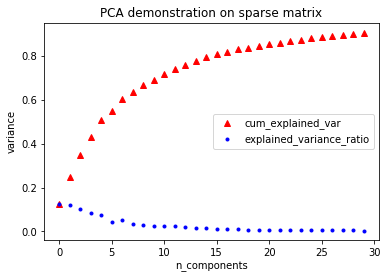

In [10]:

cum_explained_var = []
for i in range(0, len(svd.explained_variance_ratio_)):
    if i == 0:
        cum_explained_var.append(svd.explained_variance_ratio_[i])
    else:
        cum_explained_var.append(svd.explained_variance_ratio_[i] + 
                                 cum_explained_var[i-1])
# print(cum_explained_var) 
cmv, = plt.plot(cum_explained_var, 'r^', label = 'cum_explained_var')
evr, = plt.plot(svd.explained_variance_ratio_, 'b.', label = 'explained_variance_ratio')
plt.legend(handles=[cmv, evr])
plt.xlabel('n_components')
plt.ylabel('variance')
plt.title('PCA demonstration on sparse matrix')
plt.show()

## 7. Distance Matrix computation & Ordination

In [11]:

# Compute the distance matrix (using cosine similarity for simplicity here)

# D = pairwise_distances(X, metric = 'cosine')
D_new = pairwise_distances(X_new, metric = 'cosine')


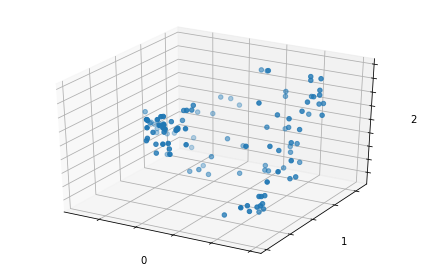

In [12]:
from skbio.stats.ordination import pcoa
pcoa(D_new)

In [13]:
# Use rpy2 to run R within Python

import rpy2
print(rpy2.__version__)
from rpy2.robjects.packages import importr

import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
# import R's packages
base = importr('base')
utils = importr('utils')
cluster = importr('cluster')


2.9.2


# 8. Peform Clustering based on Distance Matrix

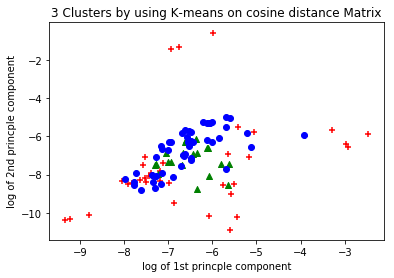

In [14]:
num_clusters = 3
p = cluster.pam(D_new,num_clusters)

pc1 = np.log(X_new[:,0])
pc2 = np.log(X_new[:,1])


# print(p[2])
cluster_assignment = np.array(p[2])
# print(cluster_assignment)
idxs = []
for i in range(num_clusters):
    idxs.append(np.where(cluster_assignment == (i+1))[0])
# print(idxs)

plt.scatter(pc1[idxs[0]],pc2[idxs[0]],c='r', marker='+')
plt.scatter(pc1[idxs[1]],pc2[idxs[1]],c='g', marker='^')
plt.scatter(pc1[idxs[2]],pc2[idxs[2]],c='b', marker='o')


plt.xlabel('log of 1st princple component')
plt.ylabel('log of 2nd princple component')
plt.title('3 Clusters by using K-means on cosine distance Matrix')
plt.show()

# 9. Important Features and corresponding taxonomy

In [15]:
# Feature importance by Random Forest model based on cluster result

from sklearn.ensemble import ExtraTreesClassifier

# feature extraction
x = X.todense()
model = ExtraTreesClassifier()
model.fit(x, cluster_assignment)
imp_feat = model.feature_importances_


In [16]:
# get top 10 important features
top = sorted(range(len(imp_feat)), key=lambda i: imp_feat[i], reverse=True)[:10]
# print("important scores:", imp_feat[top])
for i in range(len(top)):
    print("Top", i, ", index:", top[i], table.metadata(axis = 'observation')[top[i]]['taxonomy'])
    

Top 0 , index: 116240 ['k__Bacteria', 'p__Actinobacteria', 'c__Actinobacteria', 'o__Actinomycetales', 'f__Nocardioidaceae', 'g__Nocardioides', 's__']
Top 1 , index: 20480 ['k__Bacteria', 'p__Actinobacteria', 'c__Acidimicrobiia', 'o__Acidimicrobiales', 'f__EB1017', 'g__', 's__']
Top 2 , index: 196006 ['k__Bacteria', 'p__Bacteroidetes', 'c__[Saprospirae]', 'o__[Saprospirales]', 'f__Chitinophagaceae', 'g__', 's__']
Top 3 , index: 8350 ['k__Bacteria', 'p__Verrucomicrobia', 'c__[Pedosphaerae]', 'o__[Pedosphaerales]', 'f__auto67_4W', 'g__', 's__']
Top 4 , index: 154547 ['k__Bacteria', 'p__Elusimicrobia', 'c__Elusimicrobia', 'o__FAC88', 'f__', 'g__', 's__']
Top 5 , index: 296296 ['k__Bacteria', 'p__Proteobacteria', 'c__Alphaproteobacteria', 'o__Ellin329', 'f__', 'g__', 's__']
Top 6 , index: 157646 ['k__Bacteria', 'p__Proteobacteria', 'c__Gammaproteobacteria', 'o__Xanthomonadales', 'f__Xanthomonadaceae']
Top 7 , index: 315974 ['k__Bacteria', 'p__Proteobacteria', 'c__Deltaproteobacteria', 'o__M